In [13]:
import xarray as xr
import os
import pandas as pd
import cmweather
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dask_jobqueue import SLURMCluster
from distributed import Client, progress

In [2]:
cluster = SLURMCluster(cores=36, processes=6, memory='128GB', walltime='6:00:00')
cluster.scale(12)

In [3]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.221.70.6:8787/status,
Dashboard: http://140.221.70.6:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.221.70.6:43821,Workers: 0
Dashboard: http://140.221.70.6:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Data integrity check

In [9]:
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
for fi in listy:
    try:
        ds = xr.open_dataset(fi)
        ds.close()
    except RuntimeError:
        print("Removing %s" % fi)
        os.remove(fi)
        

## Data resampling

In [20]:
i = 0
dest_dir = '/lcrc/group/earthscience/rjackson/kazrcloudsat/hourly_ave/'
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
futures = client.map(resample_to_hour, listy)
progress(futures)


VBox()

In [19]:
del futures

In [15]:
def resample_to_hour(file_name):
    try:
        ds = xr.open_dataset(file_name)
        base, path = os.path.split(file_name)
        ds['reflectivity_best_estimate'] = ds['reflectivity_best_estimate'].where(ds['reflectivity_clutter_flag'] == 1, drop=False)
        ds['mean_doppler_velocity'] = ds['mean_doppler_velocity'].where(ds['reflectivity_clutter_flag'] == 1, drop=False)
        ds['spectral_width'] = ds['spectral_width'].where(ds['spectral_width'] == 1, drop=False)
        ds = ds.resample(time='1h').mean()
        out_path = os.path.join(dest_dir, path)
        ds.to_netcdf(out_path)
        ds.close()
    except RuntimeError:
        return

In [5]:
nsa_data_path = '/lcrc/group/earthscience/NSA/Johannes-ck-new.dat'
nsa_cluster = pd.read_csv(nsa_data_path, index_col=["time"], parse_dates=True).to_xarray()

In [21]:
nsa_cluster['class']

<xarray.DataArray 'class' (time: 6575)>
array([ 4.,  4.,  4., ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2021-12-31

In [30]:
nsa_cluster["class"].sel(time=ds.time.values[2]).values

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [9]:
dest_dir = '/lcrc/group/earthscience/rjackson/kazrcloudsat/hourly_ave/*.nc'
file_list = glob(dest_dir)
ds = xr.open_dataset(file_list[0])
heights = ds.height.values
ds.close()
refls = []
clusters = []
vels = []
for fi in file_list:
    ds = xr.open_dataset(fi)
    heights = ds.height.values
    refls.append(ds.reflectivity_best_estimate.values)
    vels.append(ds.mean_doppler_velocity.values)
    try:
        clusters.append(np.array([nsa_cluster["class"].sel(time=ds.time.values[0]).values]))
    except KeyError:
        clusters.append(np.array([np.nan]))
refls = np.concatenate(refls, axis=0)
vels = np.concatenate(vels, axis=0)
clusters = np.concatenate(clusters, axis=0)


In [72]:
refl_bins = np.linspace(-50, 20, 40)
hists_ref = np.zeros((4, len(heights), len(refl_bins) - 1))
vel_bins = np.linspace(-2, 2, 40)
hists_vel = np.zeros((4, len(heights), len(vel_bins) - 1))
medians_ref = np.zeros((4, len(heights)))
medians_vel = np.zeros((4, len(heights)))  

for c in range(4):
    which_inds = np.argwhere(clusters == c+1)
    for h in range(len(heights)):
        hist, bins = np.histogram(refls[which_inds, h], bins=refl_bins)
        hists_ref[c, h] = hist / np.sum(hist)
        medians_ref[c, h] = np.nanpercentile(refls[which_inds, h], 50)
        hist, bins = np.histogram(vels[which_inds, h], bins=vel_bins)
        hists_vel[c, h] = hist / np.sum(hist)
        medians_vel[c, h] = np.nanpercentile(vels[which_inds, h], 50)
hists_ref = np.where(hists_ref > 0, hists_ref, np.nan)
hists_vel = np.where(hists_vel > 0, hists_vel, np.nan)

/tmp/ipykernel_6339/4269008533.py:15: RuntimeWarning: divide by zero encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)
/tmp/ipykernel_6339/4269008533.py:15: RuntimeWarning: invalid value encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)
/tmp/ipykernel_6339/4269008533.py:12: RuntimeWarning: divide by zero encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/tmp/ipykernel_6339/4269008533.py:12: RuntimeWarning: invalid value encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


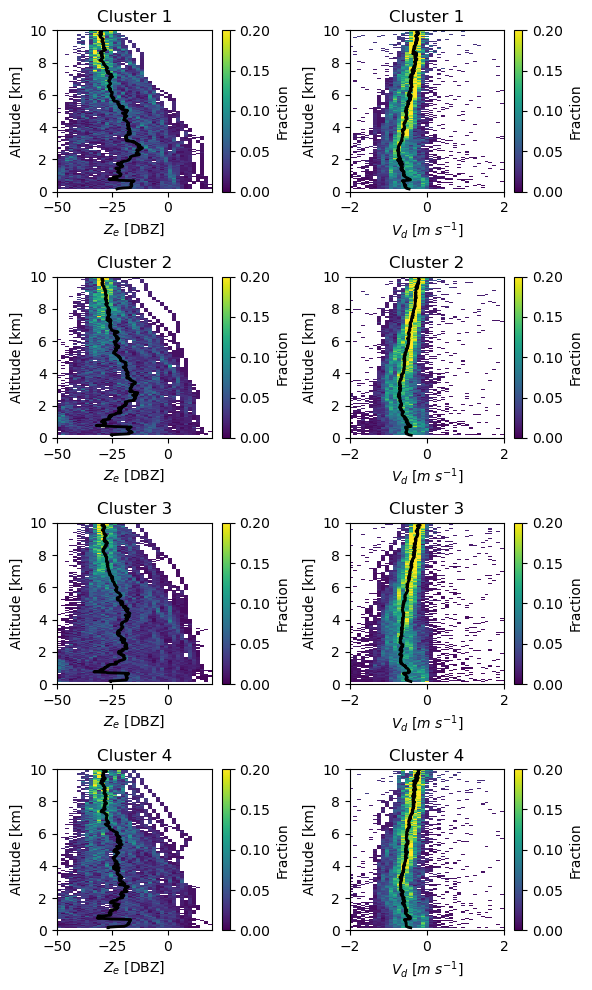

In [79]:
x_ref, y = np.meshgrid((refl_bins[:-1] + refl_bins[1:]) / 2., heights)
x_vel, y = np.meshgrid((vel_bins[:-1] + vel_bins[1:]) / 2., heights)
fig, ax = plt.subplots(4, 2, figsize=(6, 10))

for i in range(4):
    c = ax[i, 0].pcolormesh(x_ref, y / 1e3, hists_ref[i], vmin=0, vmax=0.2)
    ax[i, 0].set_xlabel("$Z_{e}$ [DBZ]")
    ax[i, 0].set_ylabel("Altitude [km]")
    ax[i, 0].plot(medians_ref[i], heights / 1e3, linewidth=2, color='k')
    plt.colorbar(c, ax =ax[i, 0], label='Fraction')
    ax[i, 0].set_title("Cluster %d" % (i + 1))
    c = ax[i, 1].pcolormesh(x_vel, y / 1e3, hists_vel[i], vmin=0, vmax=0.2)
    plt.colorbar(c, ax =ax[i, 1], label='Fraction')
    ax[i, 1].plot(medians_vel[i], heights / 1e3, linewidth=2, color='k')
    ax[i, 1].set_xlabel("$V_{d}$ [$m\ s^{-1}$]")
    ax[i, 1].set_ylabel("Altitude [km]")
    ax[i, 0].set_ylim([0, 10])
    ax[i, 1].set_ylim([0, 10])
    ax[i, 1].set_xlim([-2, 2])
    ax[i, 1].set_title("Cluster %d" % (i + 1))
fig.tight_layout()
fig.savefig('KAZR_mean_profiles.png', dpi=300, bbox_inches='tight')

In [64]:
np.nanpercentile(refls[which_inds, 3], 50)

-19.632671356201172

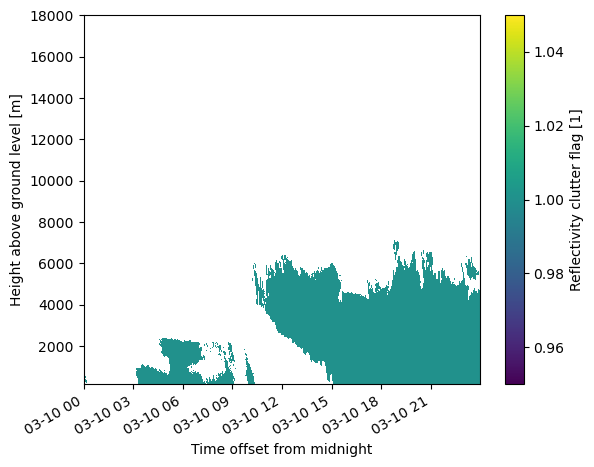

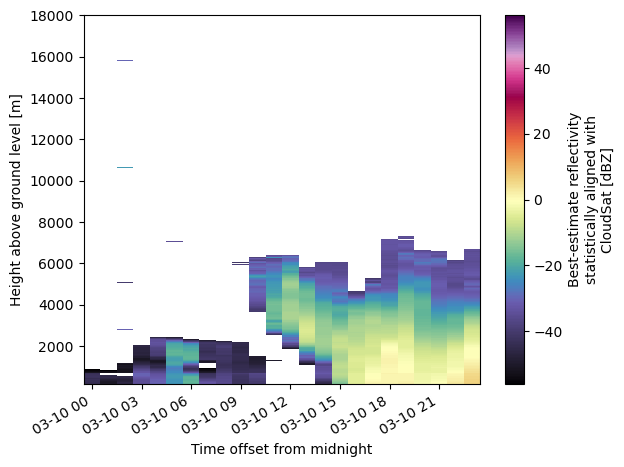

In [29]:
ds['reflectivity_best_estimate'].where(ds['reflectivity_clutter_flag'] == 1).resample(time='1h').mean().T.plot(
    cmap='ChaseSpectral'
)